In [1]:
from utils.imports import *
from utils.functions import *
from utils.paths import *

Using TensorFlow backend.


In [2]:
PATH = {'pics_path_true_val' : val_true_pics_path_3d,
        'pics_path_false_val' : val_false_pics_path_3d,
        'pics_path_true_train' : train_true_pics_path_3d,
        'pics_path_false_train' : train_false_pics_path_3d,
        'pics_path_true_test' : test_true_pics_path_3d,
        'model_path' : model_path}

In [3]:
def train_generator(PATH):
    file_list_true = get_dirfiles(PATH['pics_path_true_train'])
    file_list_false = get_dirfiles(PATH['pics_path_false_train'])
    nb_true = len(file_list_true) + len(file_list_false)
    sample = np.zeros([nb_true,64,64,64])
    labels = np.zeros([nb_true,2])
    for i in tqdm(range(len(file_list_true))):
        cc= np.load(file_list_true[i]).reshape([1,64,64,64])
        sample[i] = cc[0]
        labels[i][0] = 1
    for j in tqdm(range(len(file_list_false))):
        bb= np.load(file_list_true[i]).reshape([1,64,64,64])
        sample[j+len(file_list_true)] = bb[0]
        labels[j+len(file_list_true)][1] = 1    
    sample = np.expand_dims(sample, axis=1)        
    return sample,labels
            
def val_generator(PATH):
    file_list_true = get_dirfiles(PATH['pics_path_true_val'])
    file_list_false = get_dirfiles(PATH['pics_path_false_val'])
    nb_true = len(file_list_true) + len(file_list_false)
    sample = np.zeros([nb_true,64,64,64])
    labels = np.zeros([nb_true,2])
    for i in tqdm(range(len(file_list_true))):
        cc= np.load(file_list_true[i]).reshape([1,64,64,64])
        sample[i] = cc[0]
        labels[i][0] = 1
    for j in tqdm(range(len(file_list_false))):
        bb= np.load(file_list_true[i]).reshape([1,64,64,64])
        sample[j+len(file_list_true)] = bb[0]
        labels[j+len(file_list_true)][1] = 1
    
    sample = np.expand_dims(sample, axis=1) 
    return sample,labels

def test_generator(PATH):
    file_list_true = get_dirfiles(PATH['pics_path_true_test'])
    nb_true = len(file_list_true)
    sample = np.zeros([nb_true,64,64,64])
    for i in tqdm(range(len(file_list_true))):
        cc= np.load(file_list_true[i]).reshape([1,64,64,64])
        sample[i] = cc[0]    
    sample = np.expand_dims(sample, axis=1) 
    np.save(PATH['model_path']+"X_test.npy",sample)
    return sample

In [4]:
def load_fenge_csv(PATH,load_data = False):
    if load_data:
        X_train = np.load(PATH['model_path'] + "X_train.npy")
        Y_train = np.load(PATH['model_path'] + "Y_train.npy") 
        X_val = np.load(PATH['model_path'] + "X_val.npy") 
        Y_val = np.load(PATH['model_path'] + "Y_val.npy") 
        val_data = [X_val,Y_val]

    else:
        X_train,Y_train = train_generator(PATH)
        X_val,Y_val = val_generator(PATH)
        val_data = [X_val,Y_val]
        
        np.save(PATH['model_path'] + "X_train.npy",X_train)
        np.save(PATH['model_path'] + "Y_train.npy",Y_train) 
        np.save(PATH['model_path'] + "X_val.npy",X_val) 
        np.save(PATH['model_path'] + "Y_val.npy",Y_val) 
    return X_train,Y_train,val_data

In [5]:
def preds3d_dense(width):
    
    learning_rate = 5e-5
    #optimizer = SGD(lr=learning_rate, momentum = 0.9, decay = 1e-3, nesterov = True)
    optimizer = Adam(lr=learning_rate)
    
    inputs = Input(shape=(1, 64, 64, 64))
    conv1 = Convolution3D(width, 3, 3, 3, activation = 'relu', border_mode='same')(inputs)
    conv1 = BatchNormalization(axis = 1)(conv1)
    conv1 = Convolution3D(width*2, 3, 3, 3, activation = 'relu', border_mode='same')(conv1)
    conv1 = BatchNormalization(axis = 1)(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2), border_mode='same')(conv1)
    
    conv2 = Convolution3D(width*2, 3, 3, 3, activation = 'relu', border_mode='same')(pool1)
    conv2 = BatchNormalization(axis = 1)(conv2)
    conv2 = Convolution3D(width*4, 3, 3, 3, activation = 'relu', border_mode='same')(conv2)
    conv2 = BatchNormalization(axis = 1)(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2), border_mode='same')(conv2)

    conv3 = Convolution3D(width*4, 3, 3, 3, activation = 'relu', border_mode='same')(pool2)
    conv3 = BatchNormalization(axis = 1)(conv3)
    conv3 = Convolution3D(width*8, 3, 3, 3, activation = 'relu', border_mode='same')(conv3)
    conv3 = BatchNormalization(axis = 1)(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2), border_mode='same')(conv3)
    
    conv4 = Convolution3D(width*8, 3, 3, 3, activation = 'relu', border_mode='same')(pool3)
    conv4 = BatchNormalization(axis = 1)(conv4)
    conv4 = Convolution3D(width*16, 3, 3, 3, activation = 'relu', border_mode='same')(conv4)
    conv4 = BatchNormalization(axis = 1)(conv4)
    pool4 = MaxPooling3D(pool_size=(8, 8, 8), border_mode='same')(conv4)
    
    output = Flatten(name='flatten')(pool4)
    output = Dropout(0.2)(output)
    output = Dense(128)(output)
    output = PReLU()(output)
    output = BatchNormalization()(output)
    output = Dropout(0.2)(output)
    output = Dense(128)(output)
    output = PReLU()(output)
    output = BatchNormalization()(output)
    output = Dropout(0.3)(output)
    output = Dense(2, activation='softmax', name = 'predictions')(output)
    model3d = Model(inputs, output)
    model3d.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model3d

In [ ]:
def fenlei_fit(name, PATH,load_data = False,load_check = False,batch_size=2, epochs=10,check_name = None):

    t = time.time()
    callbacks = [EarlyStopping(monitor='val_loss', patience = 5, verbose = 1),
                 ModelCheckpoint((model_path + '{}.h5').format(name),
                                 monitor='val_loss',
                                 verbose = 0,
                                 save_best_only = True)]
    if load_check:
        check_model = (model_path + '{}.h5').format(check_name)
        model = load_model(check_model)
    else:
        #model = Resnet3DBuilder.build_resnet_18((64, 64, 64, 1), 2)
        model = preds3d_dense(16)
    x,y,val = load_fenge_csv(PATH,load_data)
    model.fit(x=x, y=y, batch_size=batch_size, epochs=epochs,
              validation_data = val,verbose=1, callbacks=callbacks, shuffle=True)
    return model

In [ ]:
model = fenlei_fit('FenLei', PATH,load_data = True,load_check = True,batch_size=2, epochs=8,check_name = 'FenLei')

Train on 7639 samples, validate on 1956 samples
Epoch 1/8
7639/7639 [==============================] - 4224s - loss: 0.4791 - acc: 0.7709 - val_loss: 2.3733 - val_acc: 0.3604
Epoch 2/8
7639/7639 [==============================] - 4216s - loss: 0.4587 - acc: 0.7785 - val_loss: 2.5664 - val_acc: 0.3696
Epoch 3/8
5274/7639 [===================>..........] - ETA: 1161s - loss: 0.4557 - acc: 0.7664

In [ ]:
model = load_model('/Volumes/solo/ali/Data/model/FenLei.h5')

In [ ]:
X_test = test_generator(PATH)

In [ ]:
cc = model.predict(X_test,batch_size=2, verbose=0)
aa = np.zeros(cc.shape[0])
for i in range(cc.shape[0]):
    aa[i] = cc[i][0]
aa = pd.DataFrame({'result':aa,})
aa.to_csv('result.csv')

In [ ]:
val = np.load(PATH['model_path'] + "X_val.npy") 
val_result = model.predict(val,batch_size=2, verbose=0)
aa = np.zeros(val_result.shape[0])
for i in range(cc.shape[0]):
    aa[i] = cc[i][0]
aa = pd.DataFrame({'result_val':aa,})
aa.to_csv('result_val.csv')

In [ ]:
val_true = np.load(PATH['model_path'] + "Y_val.npy") 

In [ ]:
aa = np.zeros(val_true.shape[0])
for i in range(val_true.shape[0]):
    aa[i] = np.argmax(val_true[i])
aa = pd.DataFrame({'result_val':val_true,})
aa.to_csv('result_val_true.csv')

In [103]:
img = np.load('/Volumes/solo/ali/Data/train_mask/lung_mask/rand_LKDS-00013_000702.npy')


In [104]:
img.shape

(128, 128, 128)

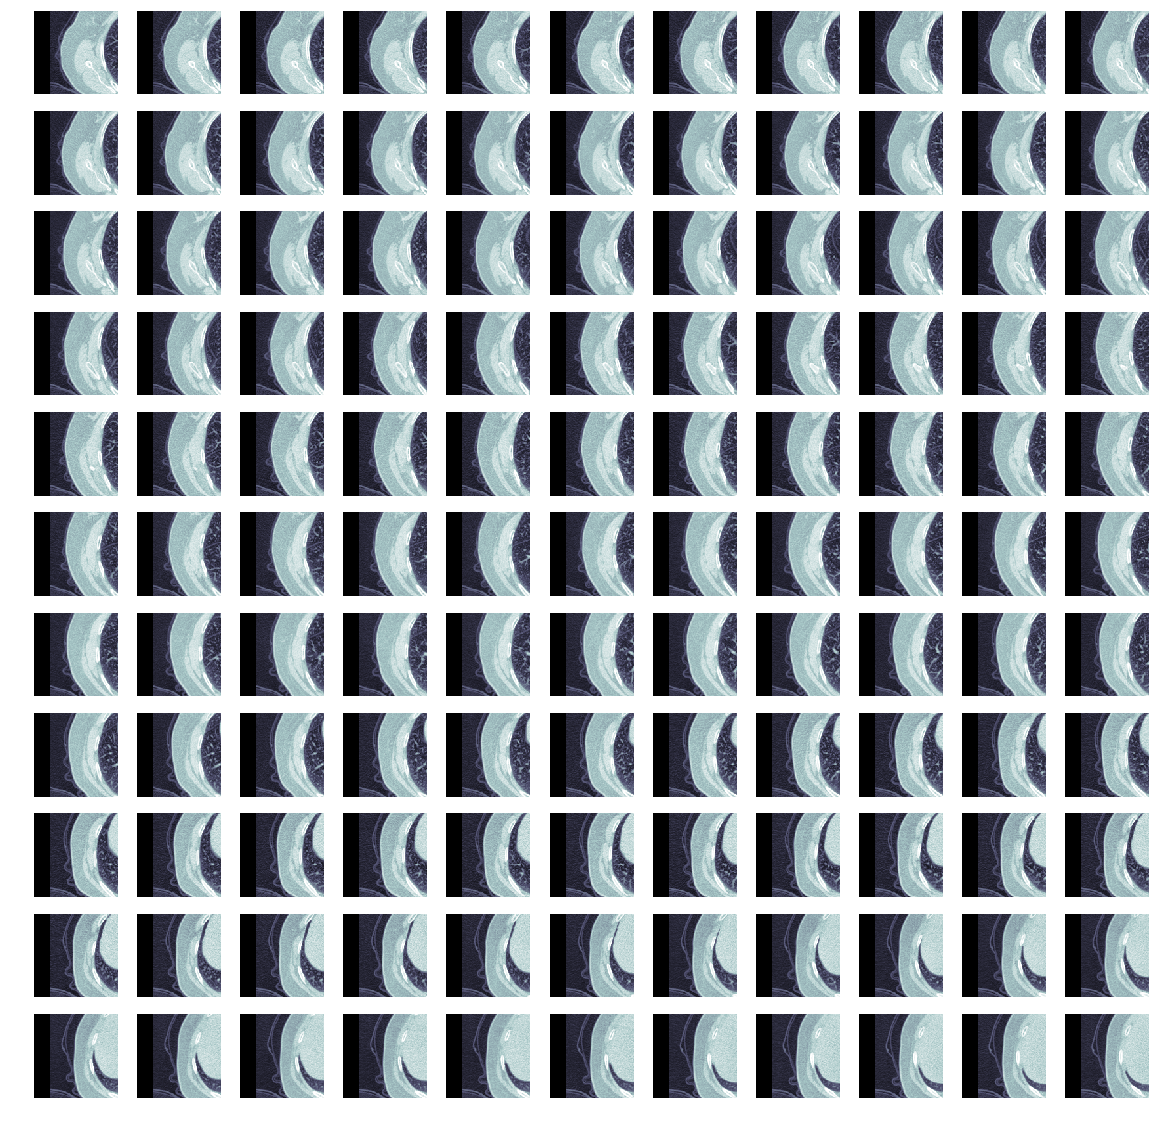

In [105]:
%matplotlib inline
f, plots = plt.subplots(11, 11, sharex='all', sharey='all', figsize=(20, 20))
# matplotlib is drunk

for i in range(121):
    plots[i // 11, i % 11].axis('off')
    plots[i // 11, i % 11].imshow(img[i], cmap=plt.cm.bone)

In [2]:
img = np.load('/Volumes/solo/ali/Data/val_mask/val_full_lung/LKDS-00999.npy')

In [5]:
img = np.squeeze(img.shape)

In [ ]:
img.shape

In [6]:
f, plots = plt.subplots(11, 11, sharex='all', sharey='all', figsize=(20, 20))
# matplotlib is drunk
%matplotlib inline
for i in range(121):
    plots[i // 11, i % 11].axis('off')
    plots[i // 11, i % 11].imshow(img[i], cmap=plt.cm.bone)

TypeError: Invalid dimensions for image data

In [108]:
cc = np.squeeze(img)
cc = label(cc)

In [109]:
np.unique(cc)

array([0])

In [2]:
glob('/Volumes/solo/ali/Data/test_pic/')

['/Volumes/solo/ali/Data/test_pic/']

In [4]:
os.listdir('/Volumes/solo/ali/Data/test_pic/LKDS-00012')

['img_0000_i.png',
 'img_0000_m.png',
 'img_0000_masseso.png',
 'img_0001_i.png',
 'img_0001_m.png',
 'img_0001_masseso.png',
 'img_0002_i.png',
 'img_0002_m.png',
 'img_0002_masseso.png',
 'img_0003_i.png',
 'img_0003_m.png',
 'img_0003_masseso.png',
 'img_0004_i.png',
 'img_0004_m.png',
 'img_0004_masseso.png',
 'img_0005_i.png',
 'img_0005_m.png',
 'img_0005_masseso.png',
 'img_0006_i.png',
 'img_0006_m.png',
 'img_0006_masseso.png',
 'img_0007_i.png',
 'img_0007_m.png',
 'img_0007_masseso.png',
 'img_0008_i.png',
 'img_0008_m.png',
 'img_0008_masseso.png',
 'img_0009_i.png',
 'img_0009_m.png',
 'img_0009_masseso.png',
 'img_0010_i.png',
 'img_0010_m.png',
 'img_0010_masseso.png',
 'img_0011_i.png',
 'img_0011_m.png',
 'img_0011_masseso.png',
 'img_0012_i.png',
 'img_0012_m.png',
 'img_0012_masseso.png',
 'img_0013_i.png',
 'img_0013_m.png',
 'img_0013_masseso.png',
 'img_0014_i.png',
 'img_0014_m.png',
 'img_0014_masseso.png',
 'img_0015_i.png',
 'img_0015_m.png',
 'img_0015_masses

In [14]:
cc = cv2.imread('/Volumes/solo/ali/Data/test_pic/LKDS-00012/img_0188_masseso.png')

In [15]:
cc = cc.transpose(2,0,1)

In [16]:
cc.shape

(3, 512, 512)

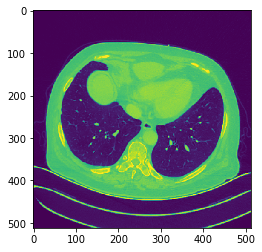

In [17]:
%matplotlib inline
plt.imshow(cc[0])

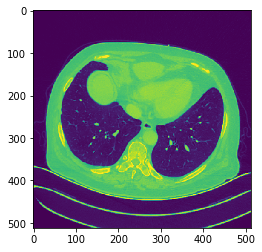

In [18]:
plt.imshow(cc[1])

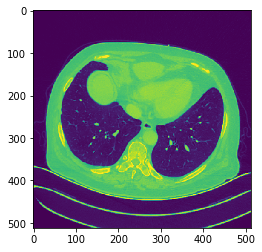

In [19]:
%matplotlib inline
plt.imshow(cc[2])

In [1]:
from utils.imports import *
from utils.functions import *
from utils.paths import *

%matplotlib inline


dropout_rate = 0.5
width = 64

Using TensorFlow backend.


In [6]:
PATH = {'annotations_path' : annotations_val_path,
        'src' : src_val,
        'dst_nodules' : mask_val,
        'dst_full_lungs' : full_lung_val,
        'model_path' : model_path,
        
        'dropout_rate' : dropout_rate,
        'width' : width,}

In [7]:
patients = load_train(PATH)

In [ ]:
r = Parallel(n_jobs=-1)(delayed(create_masks_for_test)(patient,PATH) for patient in tqdm(sorted(patients)))
i = zip(*r)

 15%|█▌        | 30/200 [11:45<52:18, 18.46s/it]  

In [ ]:
save_test_full_to_csv(i,PATH)